In [1]:
# Imports 
import os
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

os.environ["pyna_language"] = 'julia'
from pyNA.pyna import pyna

In [276]:
from matplotlib import colors
class MidpointNormalize(colors.Normalize):
"""
Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
"""
def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
    self.midpoint = midpoint
    colors.Normalize.__init__(self, vmin, vmax, clip)

def __call__(self, value, clip=None):
    # I'm ignoring masked values and all kinds of edge cases to make a
    # simple example...
    x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
    return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

fig, ax = plt.subplots(1,3,figsize=(15,3), sharey=True, dpi=300)
plt.style.use('../utils/plot.mplstyle')
fontsize = 14

epnl_tot = epnl_lat + epnl_fly



In [2]:
engine = dict()
trajectory = dict()
name_lst = ['stca_annex16', 'stca_advanced', 'ptcb_21_7']

for name in name_lst:
    engine[name] = pd.read_csv('../cases/stca/engine/PTCB/PTCB/engine_'+name+'.csv')
    trajectory[name] = pd.read_csv('../cases/stca/trajectory/PTCB/PTCB/trajectory_'+name+'.csv')      

In [66]:
# Compute sideline noise
pyna_settings = pyna.load_settings(case_name='stca')
py = pyna(pyna_settings)

# Compute noise for the different trajectories
n = 341
epnl_sideline = np.zeros((np.size(name_lst), n))
epnl_lateral = np.zeros(np.size(name_lst))
epnl_flyover = np.zeros(np.size(name_lst))
epnl_takeoff = np.zeros(np.size(name_lst))

for i, name in enumerate(name_lst):
    pyna_settings.engine_file_name = 'PTCB/PTCB/engine_' + name + '.csv'
    pyna_settings.trajectory_file_name = 'PTCB/PTCB/trajectory_' + name + '.csv'
    pyna_settings.levels_int_metric = 'epnl' 
    pyna_settings.observer_lst = {'contours',}
    
    x = np.linspace(0, 8500, n)
    pyna_settings.x_observer_array = np.zeros((n+1, 3))
    pyna_settings.x_observer_array[:-1,0] = x
    pyna_settings.x_observer_array[:-1,1] = 450.*np.ones(n)
    pyna_settings.x_observer_array[:-1,2] = 4*0.3048*np.ones(n)
    pyna_settings.x_observer_array[-1,:] = np.array((6500., 0., 4*0.3048))

    py = pyna(pyna_settings)
    py.compute_noise_time_series()
    
    epnl_sideline[i,:] = py.problem.get_val('noise.epnl')[:-1]
    epnl_lateral[i] = np.max(py.problem.get_val('noise.epnl')[:-1])
    epnl_flyover[i] = py.problem.get_val('noise.epnl')[-1]
    epnl_takeoff[i] = epnl_lateral[i] + epnl_flyover[i] 


/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, /Users/laurensvoet/Documents/Research/pyNA/pyNA/cases/stca/dymos_solution.db, is being overwritten.


Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.


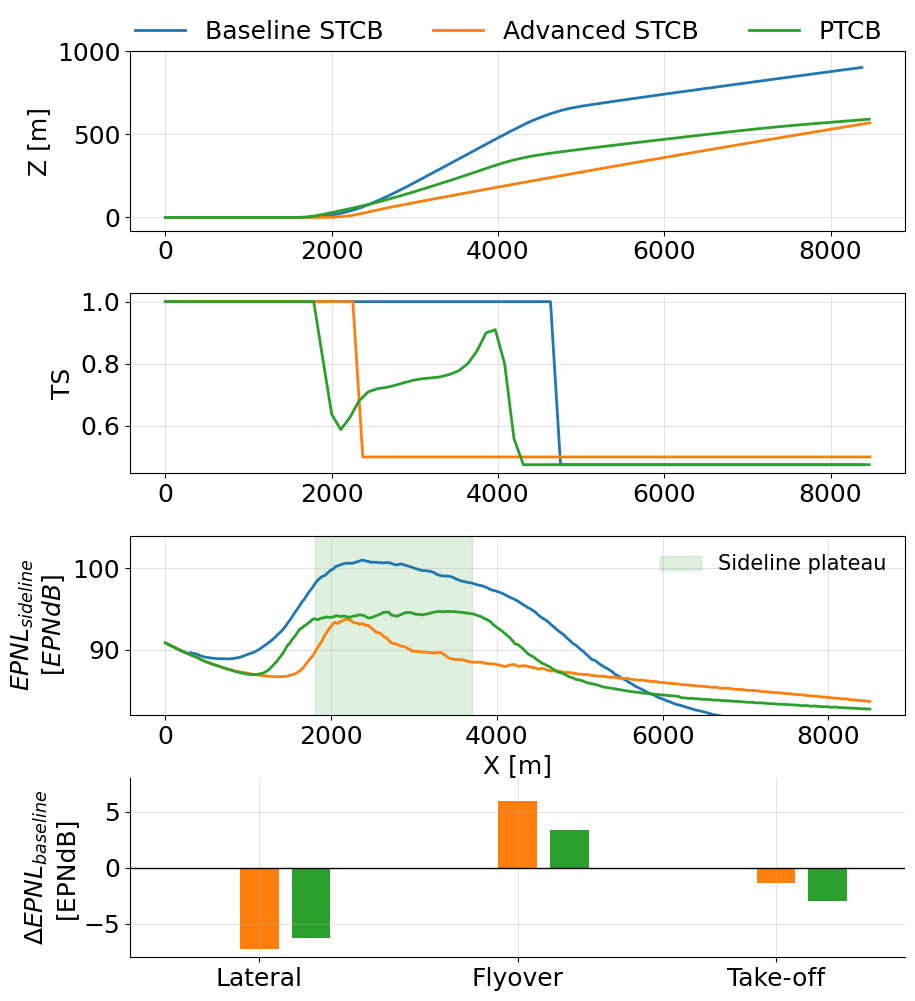

In [234]:
fig, ax = plt.subplots(4,1, figsize=(10,12))
plt.style.use('../utils/plot.mplstyle')
colors = ['tab:blue', 'tab:orange', 'tab:green']
names = ['Baseline STCB', 'Advanced STCB', 'PTCB']

# Plot trajectories
for i, name in enumerate(name_lst):
    idx_i = np.where(trajectory[name]['X [m]'] <= 8500)[0]
    
    ax[0].plot(trajectory[name]['X [m]'][idx_i], trajectory[name]['Z [m]'][idx_i], label=names[i])
    
    ax[1].plot(trajectory[name]['X [m]'][idx_i], trajectory[name]['TS [-]'][idx_i])
    
    ax[2].plot(x, epnl_sideline[i,:], color=colors[i])

    if i == 2:
        ax[2].fill_between([1800, 3700], [82, 82], [104, 104], alpha=0.15, color=colors[i], label='Sideline plateau')
    

ax[0].set_ylim([-80, 1001])
ax[0].set_ylabel('Z [m]')
ax[0].legend(bbox_to_anchor=(1,1.3), ncol=3, frameon=False)

ax[1].set_ylabel('TS')

ax[2].set_xlabel('X [m]')
ax[2].set_ylabel('$EPNL_{sideline}$\n$[EPNdB]$')
ax[2].legend(frameon=False, fontsize=15)
ax[2].set_ylim([82, 104])

# Plot noise
delta_l = epnl_lateral-epnl_lateral[0]
delta_f = epnl_flyover-epnl_flyover[0]
delta_t = delta_l + delta_f

bar_l = ax[3].bar(np.linspace(-0.2, +0.2, 3), delta_l, width=0.15, color=['tab:blue', 'tab:orange', 'tab:green'])
bar_f = ax[3].bar(np.linspace(-0.2, +0.2, 3)+1, delta_f, width=0.15, color=['tab:blue', 'tab:orange', 'tab:green'])
bar_t = ax[3].bar(np.linspace(-0.2, +0.2, 3)+2, delta_t, width=0.15, color=['k', 'tab:orange', 'tab:green'])
ax[3].set_xticks(np.arange(3))
ax[3].set_xticklabels(['Lateral', 'Flyover', 'Take-off'])

ax[3].spines['right'].set_visible(False)
ax[3].spines['top'].set_visible(False)

ax[3].plot([-0.5,2.5], [0,0], 'k', linewidth=1)
ax[3].set_xlim([-0.5, 2.5])
ax[3].set_ylim([-8,8])

ax[3].set_ylabel('$\Delta EPNL_{baseline}$\n[EPNdB]')

plt.subplots_adjust(hspace=0.35)